# Classificiation of single and double events
This notebook aims to build a model capable of classifying single and double events in a mixed dataset.

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import sys
import matplotlib.pyplot as plt
import master_data_functions.functions as dfunc

# silence deprecation warnings from tensorflow
import warnings
warnings.simplefilter('ignore', FutureWarning)

# File import
# Sample filenames are:
# CeBr10kSingle_1.txt -> single events, 
# CeBr10kSingle_2.txt -> single events
# CeBr10k_1.txt -> mixed single and double events 
# CeBr10.txt -> small file of 10 samples

keywords = {
    "single_1": "CeBr10kSingle_1",
    "single_2": "CeBr10kSingle_2",
    "mix": "CeBr10k_1",
    "small": "CeBr10",
    "simulated": "CeBr2Mil_Mix"}
    
dataset = "simulated"
data = dfunc.import_data("simulated")
images = data[keywords[dataset]]["images"]
energies = data[keywords[dataset]]["energies"]
positions = data[keywords[dataset]]["positions"]
labels = to_categorical(data[keywords[dataset]]["labels"])
n_classes = labels.shape[1]


print("Number of classes: {}".format(n_classes))
print("Energies shape: {}".format(energies.shape))
print("Positions shape: {}".format(positions.shape))
print("Labels shape: {}".format(labels.shape))
      

Number of classes: 2
Energies shape: (2000000, 2)
Positions shape: (2000000, 4)
Labels shape: (2000000, 2)



## Set up training and test data

In [8]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2)
print("Training and test data shapes:")
print("x_train: {}".format(x_train.shape))
print("x_test: {}".format(x_test.shape))
print("y_train: {}".format(y_train.shape))
print("y_test: {}".format(y_test.shape))


MemoryError: Unable to allocate array with shape (2000000, 16, 16, 1) and data type float64

## Build and compile model
Using Keras as our framework with Tensorflow backend

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend

# Set up sequential model like Labollitas project to reproduce results
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(n_classes))
model.add(Activation('softmax'))


# Compile model
# Originally adadelta optimizer
model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=["acc"])

# Output summary of model
print(model.summary())



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 32)        320       
_________________________________________________________________
activation (Activation)      (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 64)          0         
_________________________________________________________________
dense (Dense)                (None, 7, 7, 128)         8

## Train the model
We also output the mean squared error and R2-score as evaluation metrics

In [4]:
# Parameters for the model
batch_size = 128
epochs = 25

history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_data=(x_test, y_test), 
                    shuffle=True)

W0821 13:06:43.689714 140236725401408 deprecation.py:323] From /home/geir/git/master_analysis/notebooks/pretrained/pretrained_venv/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 8000 samples, validate on 2000 samples
Epoch 1/25
8000/8000 [==============================] - 5s 566us/sample - loss: 6.7945 - acc: 0.5153 - val_loss: 6.4517 - val_acc: 0.5300
Epoch 2/25
8000/8000 [==============================] - 5s 563us/sample - loss: 6.7488 - acc: 0.5151 - val_loss: 6.4353 - val_acc: 0.5305
Epoch 3/25
8000/8000 [==============================] - 4s 467us/sample - loss: 6.8289 - acc: 0.5117 - val_loss: 6.4163 - val_acc: 0.5315
Epoch 4/25
8000/8000 [==============================] - 4s 465us/sample - loss: 6.8828 - acc: 0.5052 - val_loss: 6.4026 - val_acc: 0.5325
Epoch 5/25
8000/8000 [==============================] - 4s 501us/sample - loss: 6.6852 - acc: 0.5196 - val_loss: 6.3888 - val_acc: 0.5315
Epoch 6/25
8000/8000 [==============================] - 4s 489us/sample - loss: 6.6576 - acc: 0.5205 - val_loss: 6.3703 - val_acc: 0.5355
Epoch 7/25
8000/8000 [==============================] - 4s 479us/sample - loss: 6.7370 - acc: 0.5178 - val_loss: 6.3664 - va

## Plot history of metrics on training and test set

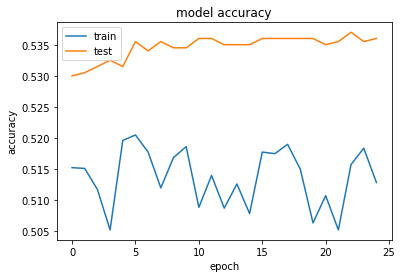

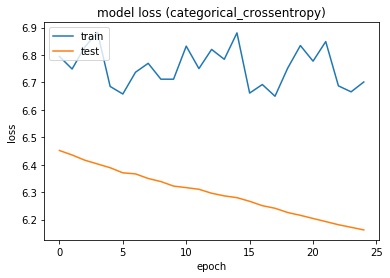

In [5]:
%matplotlib inline

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss (categorical_crossentropy)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()